# Fun with Filters and Frequencies!

Please run the below to import any important libraries

In [1]:
import os
import cv2
import numpy as np
import skimage as sk
import skimage.io as skio
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from scipy.signal import convolve2d

## Code to retrieve and output resulting image
### Functions:
- get_file_image(fname): Retrieves the image from the file.
- convert_channel_to_image(r, g, b, alpha=None): Returns a full image from red, green, blue, and alpha channels.
- get_image_channels(image): Returns the r, g, b, and alpha (if alpha exists) channels.
- get_image_channels(image, with_alpha=False): Returns a grayscaled image, useful for gradient calculation.
- red_channel: Returns the red channel of the image.
- green_channel: Returns the green channel of the image.
- blue_channel: Returns the blue channel of the image.
- alpha_channel: Returns the alpha channel of the image.

(542, 540, 4)


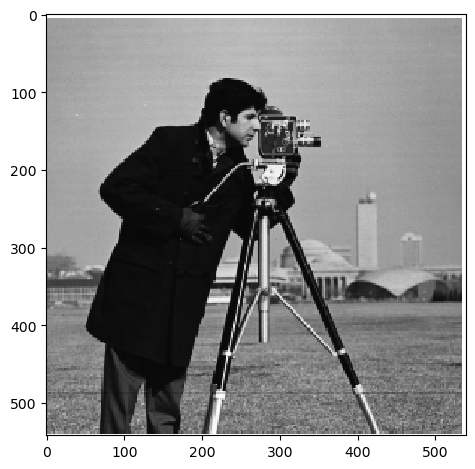

In [2]:
def get_file_image(fname):
        relative_data_dir = "data"
        dir = os.getcwd()
        image_path = os.path.join(dir, relative_data_dir, fname)

        image = skio.imread(image_path)
        image = sk.img_as_float(image)
        return image

def convert_channel_to_image(r, g, b, alpha=None):
        if alpha is None:
                return np.dstack(([r, g, b]))
        return img_as_ubyte(np.dstack([r, g, b, alpha]))

def get_image_channels(image):
        assert len(image.shape) == 3
        if image.shape[2] == 3:
                return red_channel(image), green_channel(image), blue_channel(image), None
        elif image.shape[2] == 4:
                return red_channel(image), green_channel(image), blue_channel(image), alpha_channel(image)
        else:
                raise ValueError("Image does not have 3 or 4 channels")
        
def rgb2gray(image, with_alpha=False):
        assert len(image.shape) == 3
        if image.shape[2] == 3:
                return image.dot([0.2989, 0.5870, 0.1140])
        elif image.shape[2] == 4:
                rgb_channels = image[:, :, :3]
                alpha_channel = image[:, :, 3]
                
                grayed_rgb = rgb_channels.dot([0.2989, 0.5870, 0.1140])
                return grayed_rgb + (1 - alpha_channel) if with_alpha else grayed_rgb
        else:
                raise ValueError("Image does not have 3 or 4 channels")
        

def red_channel(image):
        return image[:, :, 0]

def green_channel(image):
        return image[:, :, 1]

def blue_channel(image):
        return image[:, :, 2]

def alpha_channel(image):
        if image.shape[2] == 4:
                return image[:, :, 3]
        else:
                return None

print(get_file_image("cameraman.png").shape)
skio.imshow(get_file_image("cameraman.png"))
skio.show()

## Part 1: Fun with Filters

### Part 1.1: Finite Difference Operator

In [3]:
def gradient_magnitude_x_axis(image):
    dx = np.array([[1, -1]])

    gradient_x = convolve2d(image, dx, boundary='symm', mode='same')
    return np.abs(gradient_x)

def gradient_magnitude_y_axis(image):
    dy = np.array([[1], [-1]])

    gradient_y = convolve2d(image, dy, boundary='symm', mode='same')
    return np.abs(gradient_y)

def gradient_magnitude(image):
    gradient_mag_x = gradient_magnitude_x_axis(image)
    gradient_mag_y = gradient_magnitude_y_axis(image)
    
    return np.sqrt(gradient_mag_x ** 2 + gradient_mag_y ** 2)

Text(0.5, 1.0, 'Gradient magnitude w.r.t. both axis')

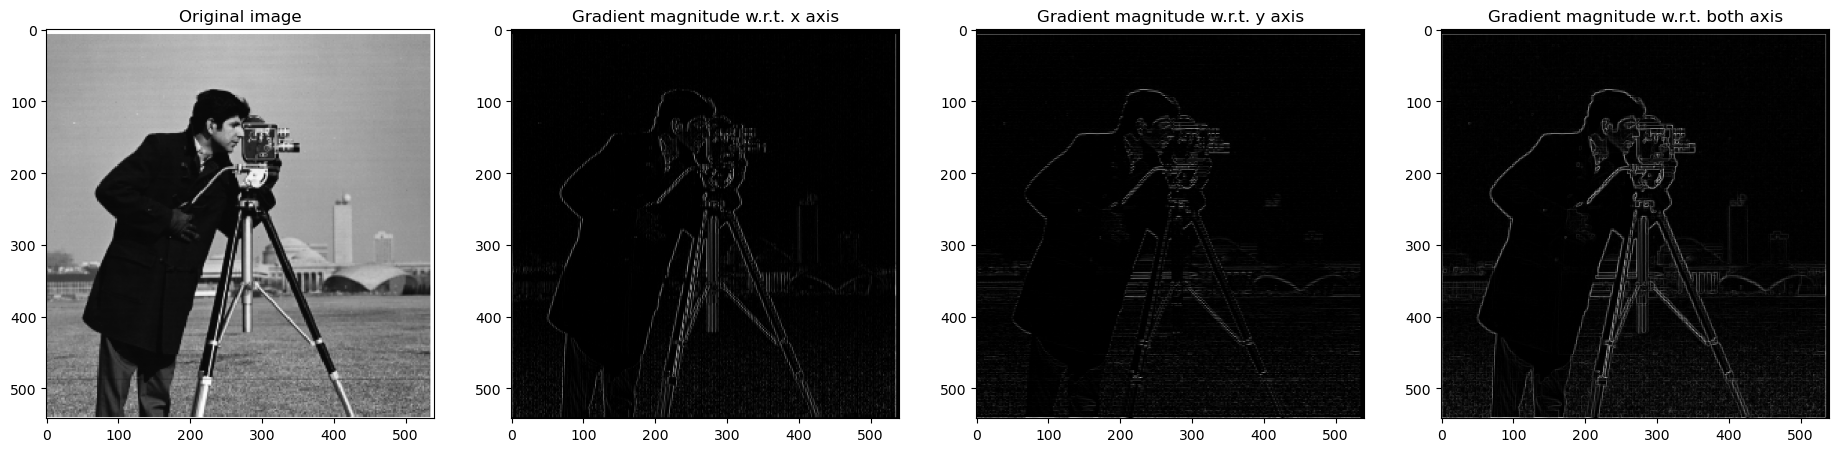

In [4]:
cameraman_im = get_file_image("cameraman.png")
grayed_cameraman_im = rgb2gray(cameraman_im)

gradient_x = gradient_magnitude_x_axis(grayed_cameraman_im)
gradient_y = gradient_magnitude_y_axis(grayed_cameraman_im)
gradient = gradient_magnitude(grayed_cameraman_im)

figure, axes = plt.subplots(1, 4, figsize=(23, 23))
axes[0].imshow(cameraman_im, cmap='gray')
axes[0].set_title("Original image")

axes[1].imshow(gradient_x, cmap='gray')
axes[1].set_title("Gradient magnitude w.r.t. x axis")

axes[2].imshow(gradient_y, cmap='gray')
axes[2].set_title("Gradient magnitude w.r.t. y axis")

axes[3].imshow(gradient, cmap='gray')
axes[3].set_title("Gradient magnitude w.r.t. both axis")

Text(0.5, 0.98, 'Binarized Images with Different Thresholds')

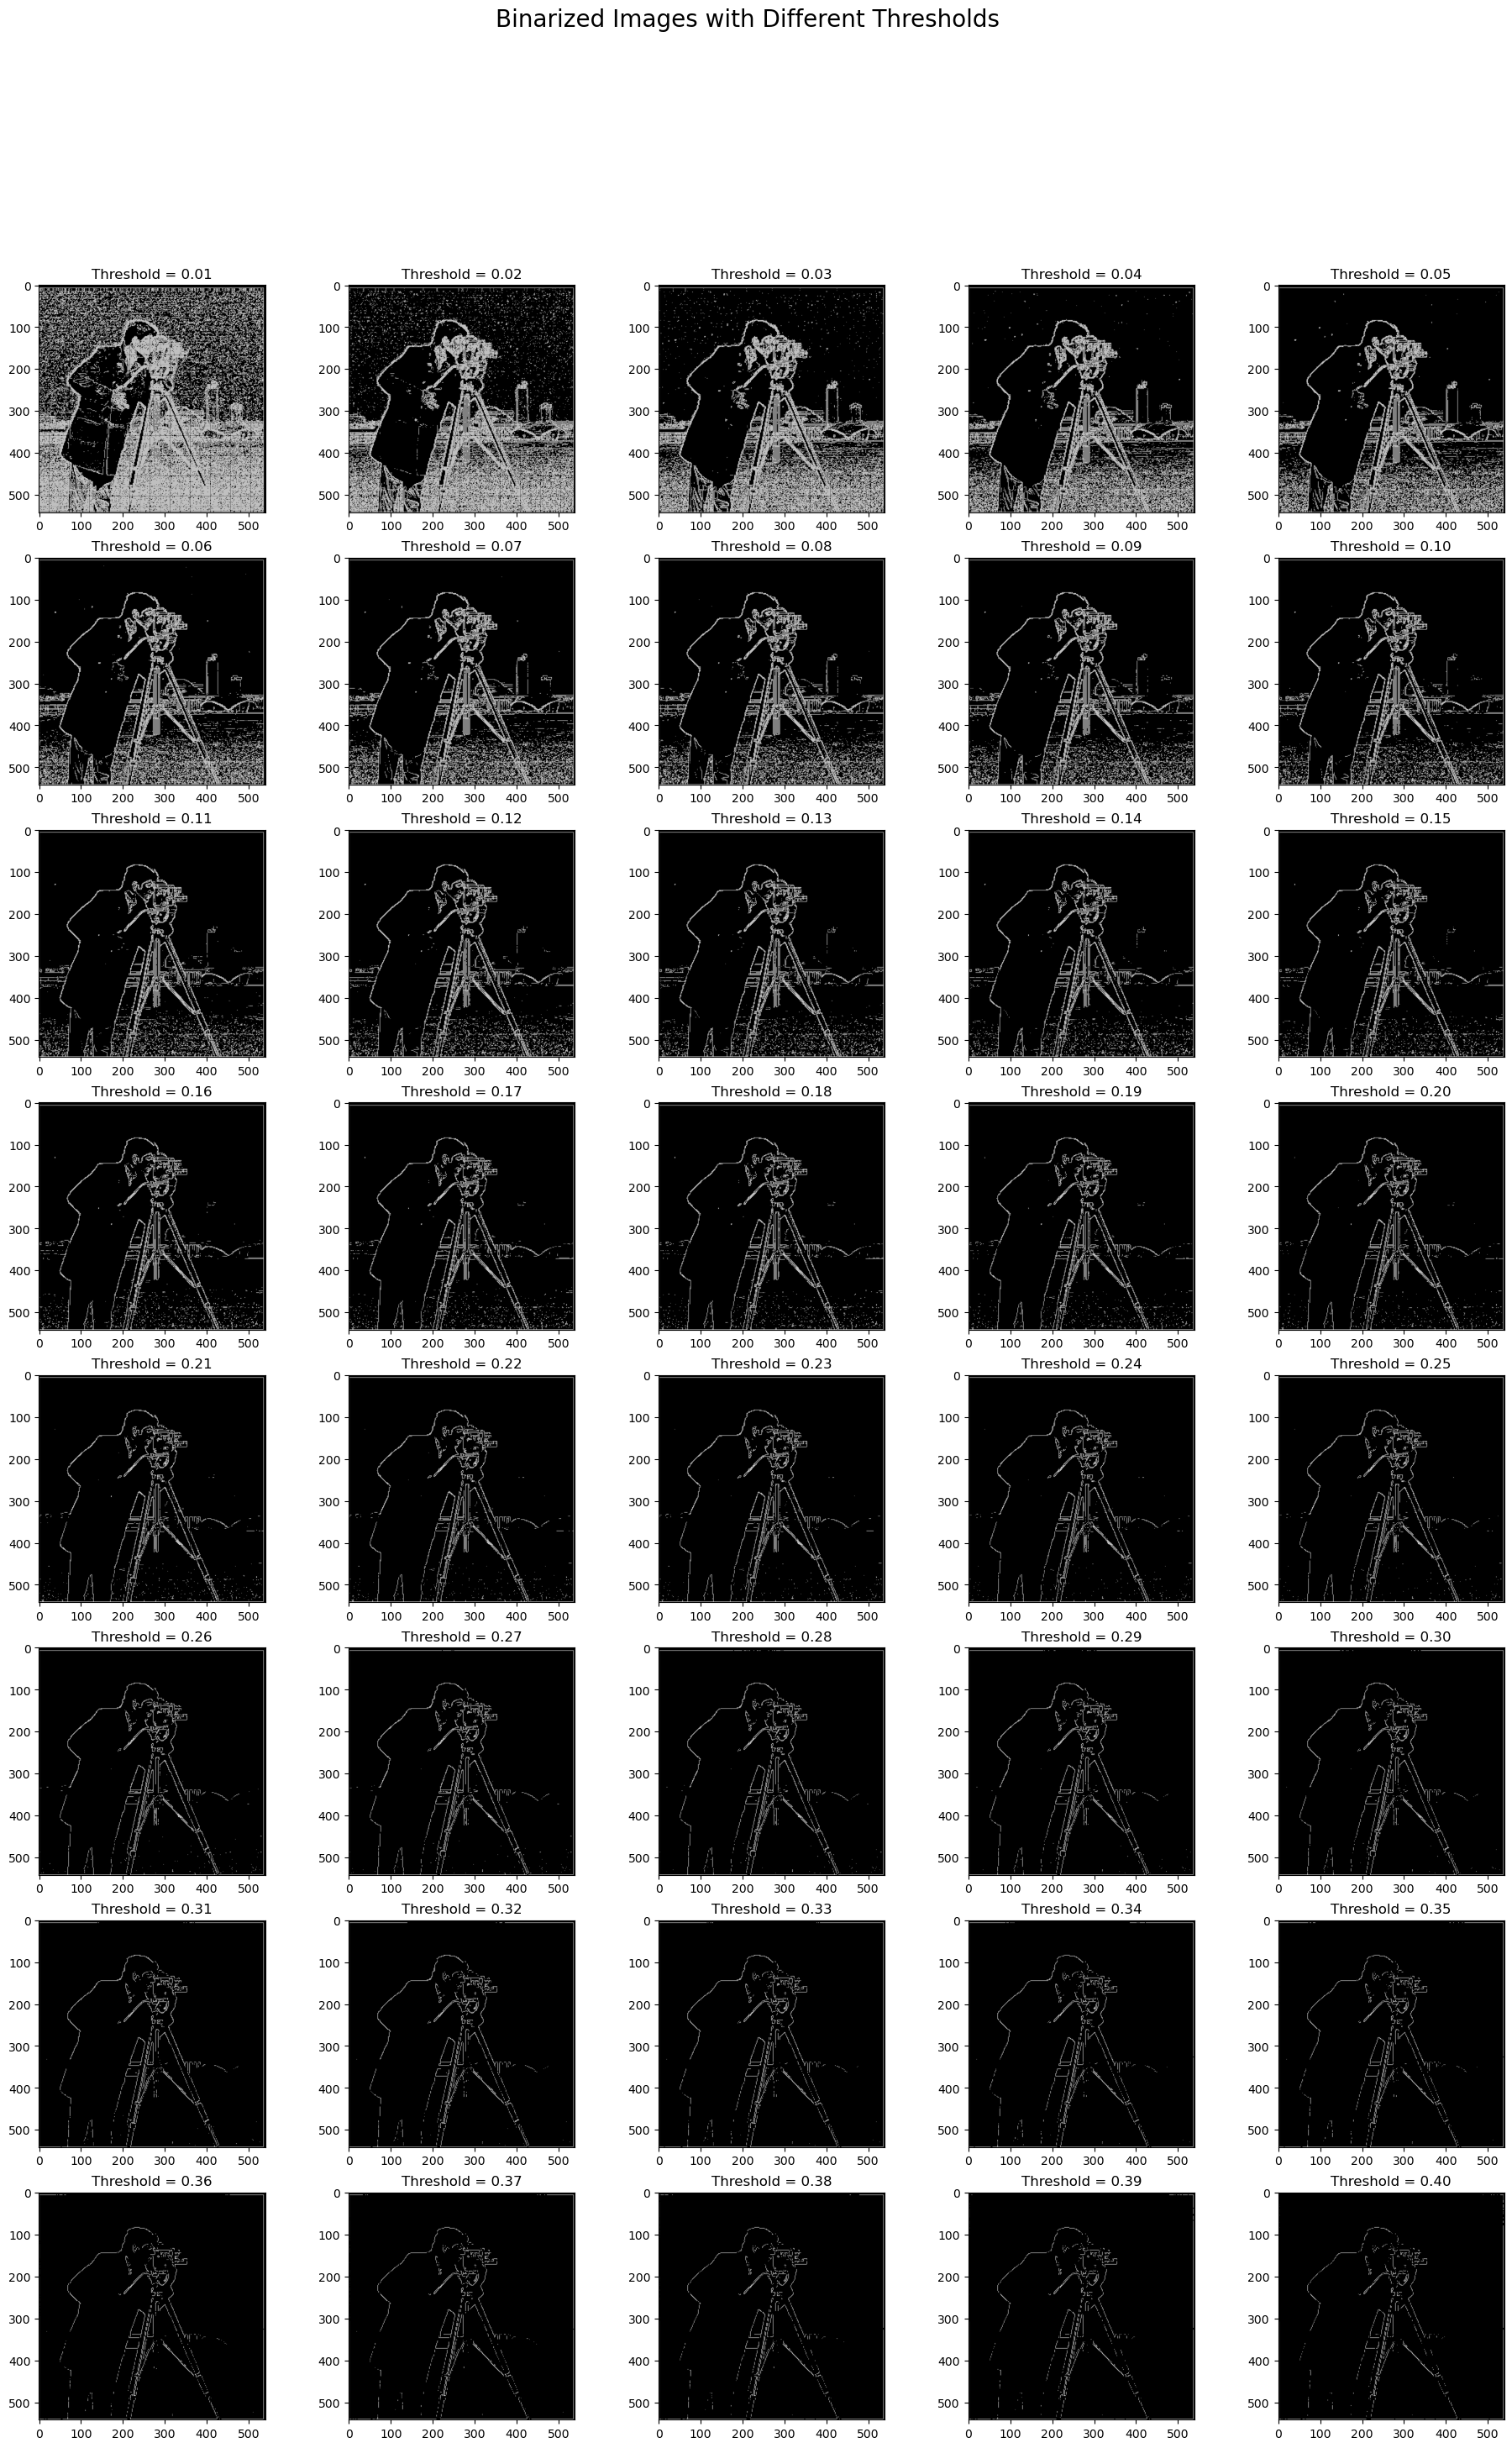

In [5]:
plot_rows = 8
plot_cols = 5
figure, axes = plt.subplots(plot_rows, plot_cols, figsize=(23, 33))

cameraman_im = get_file_image("cameraman.png")
grayed_cameraman_im = rgb2gray(cameraman_im)
gradient_cameraman = gradient_magnitude(grayed_cameraman_im)

for i in range(plot_rows * plot_cols):
    threshold = (i + 1) / 100
    gradient_cameraman_with_threshold = gradient_cameraman > threshold
    
    row = i // plot_cols
    col = i % plot_cols
    
    axes[row, col].imshow(gradient_cameraman_with_threshold, cmap='gray')
    axes[row, col].set_title("Threshold = {:.2f}".format(threshold))

plt.suptitle("Binarized Images with Different Thresholds", fontsize=20)

Text(0.5, 1.0, 'Best Threshold = 0.30')

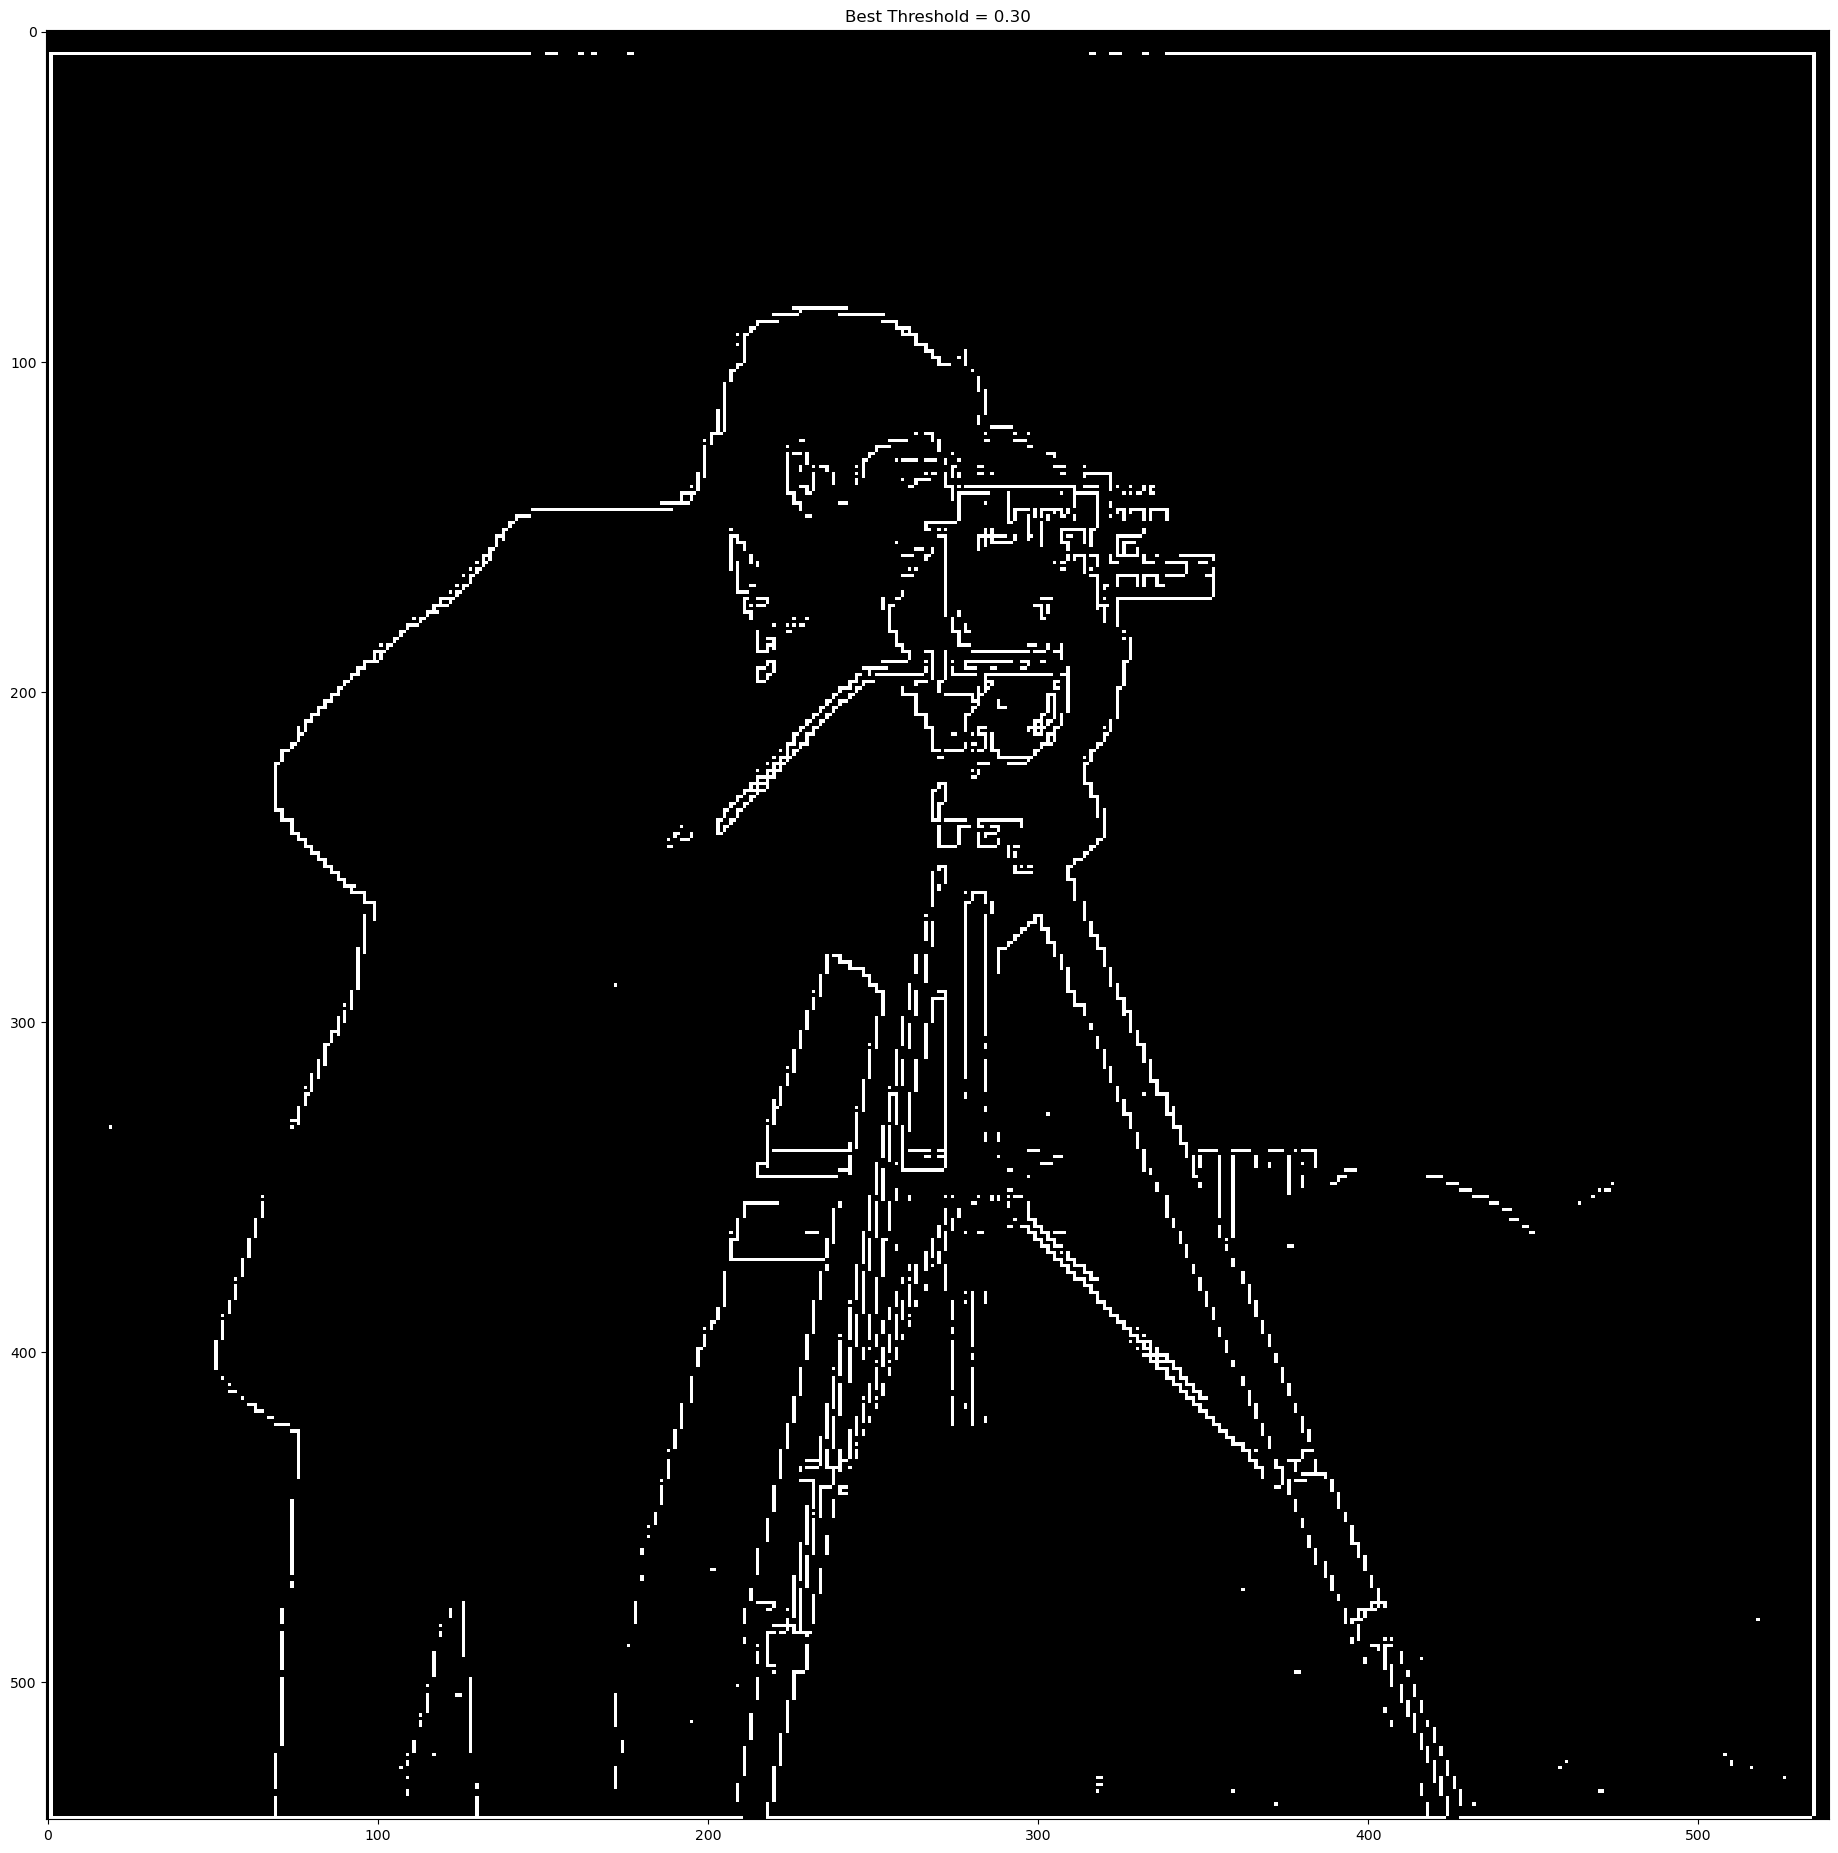

In [25]:
best_threshold = 0.30

cameraman_im = get_file_image("cameraman.png")
grayed_cameraman_im = rgb2gray(cameraman_im)
gradient_cameraman = gradient_magnitude(grayed_cameraman_im)

gradient_cameraman_with_threshold = gradient_cameraman > best_threshold

figure, axes = plt.subplots(1, 1, figsize=(23, 33))
axes.imshow(gradient_cameraman_with_threshold, cmap='gray')
axes.set_title("Best Threshold = {:.2f}".format(best_threshold))

### Part 1.2: Derivative of Gaussian (DoG) Filter

In [6]:
def get_gaussian_kernel_2d(ksize, sigma):
    k1d = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)
    k2d = k1d * k1d.T
    return k2d

Text(0.5, 0.98, 'Binarized Images with Different Thresholds')

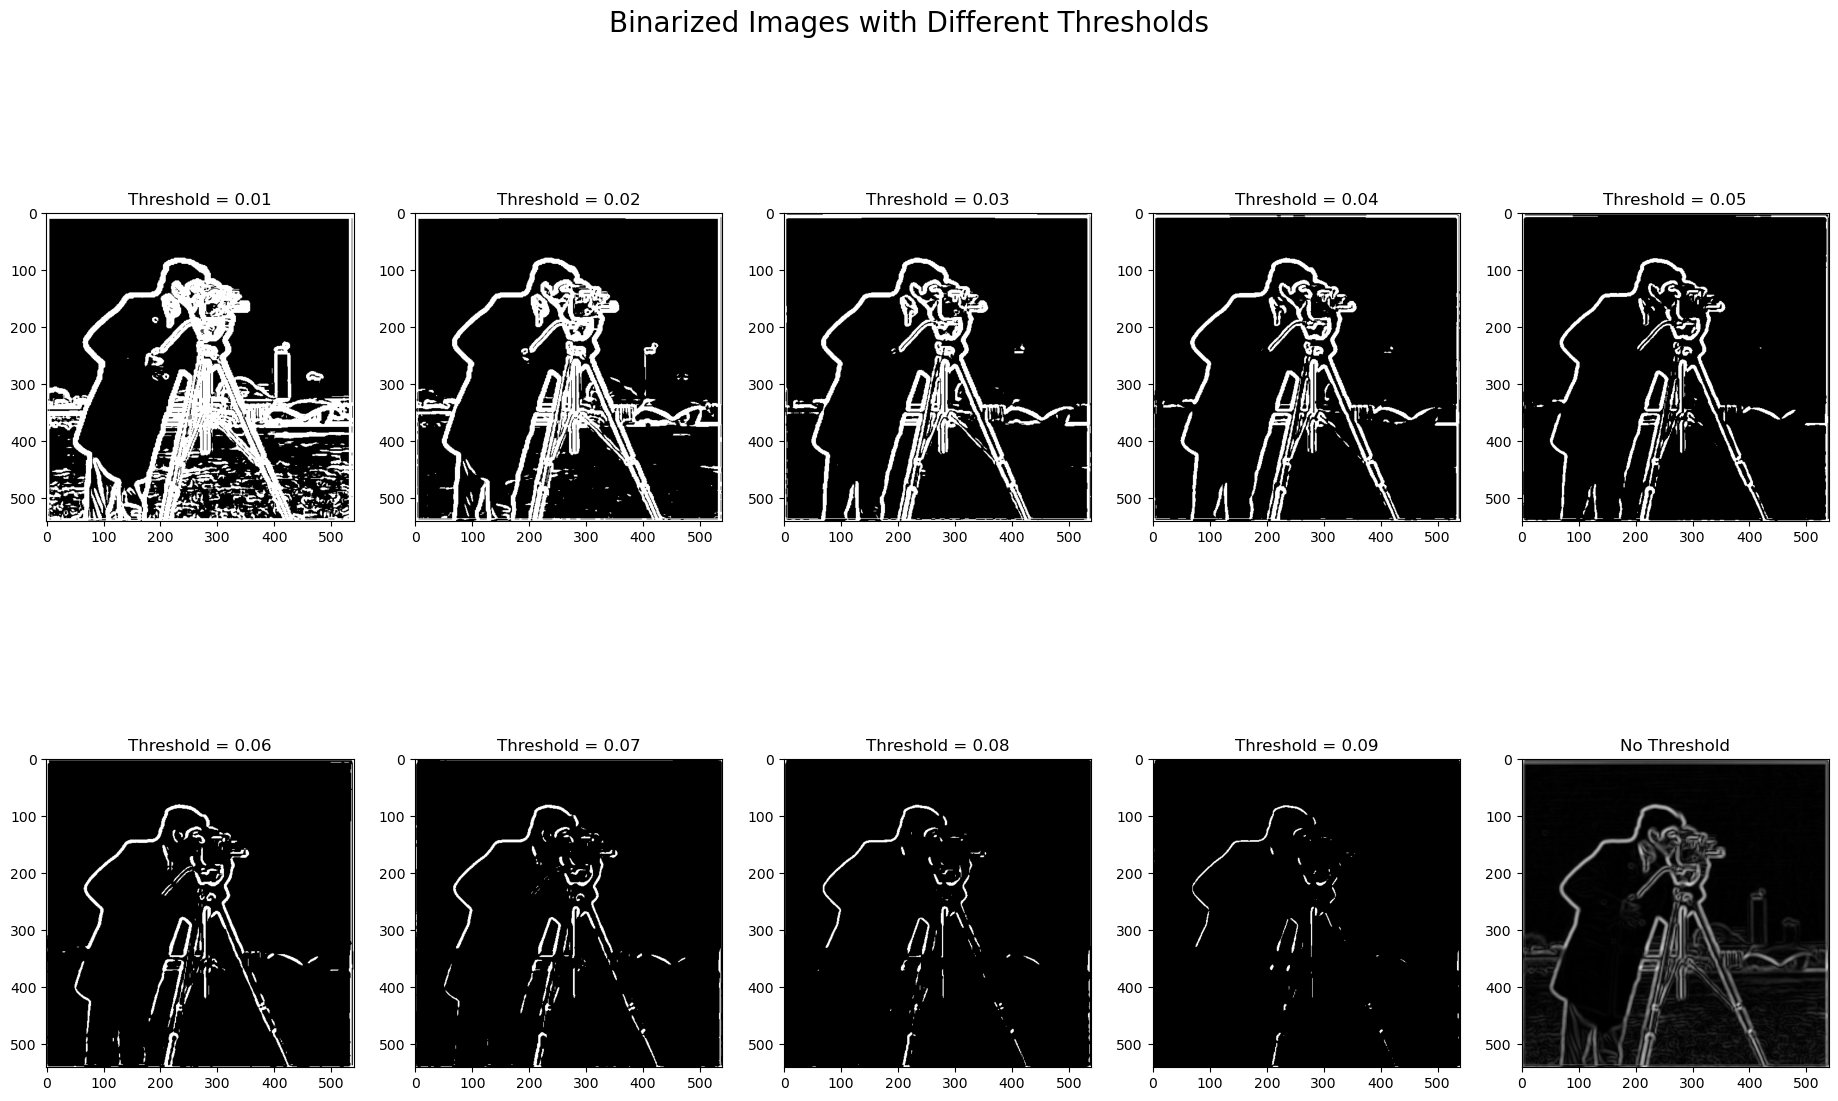

In [17]:
plot_rows = 2
plot_cols = 5
figure, axes = plt.subplots(plot_rows, plot_cols, figsize=(23, 13))

gaussian_kernel = get_gaussian_kernel_2d(9, 3)

cameraman_im = get_file_image("cameraman.png")
grayed_cameraman_im = rgb2gray(cameraman_im)
blurred_cameraman_im = convolve2d(grayed_cameraman_im, gaussian_kernel, mode="same")
gradient = gradient_magnitude(blurred_cameraman_im)

for i in range(plot_rows * plot_cols - 1):
    threshold = (i + 1) / 100
    gradient_cameraman_with_threshold = gradient > threshold
    
    row = i // plot_cols
    col = i % plot_cols
    
    axes[row, col].imshow(gradient_cameraman_with_threshold, cmap='gray')
    axes[row, col].set_title("Threshold = {:.2f}".format(threshold))

axes[plot_rows - 1, plot_cols - 1].imshow(gradient, cmap='gray')
axes[plot_rows - 1, plot_cols - 1].set_title("No Threshold")
plt.suptitle("Binarized Images with Different Thresholds", fontsize=20)

Text(0.5, 1.0, 'Gradient of Gaussian Kernel w.r.t. both axis')

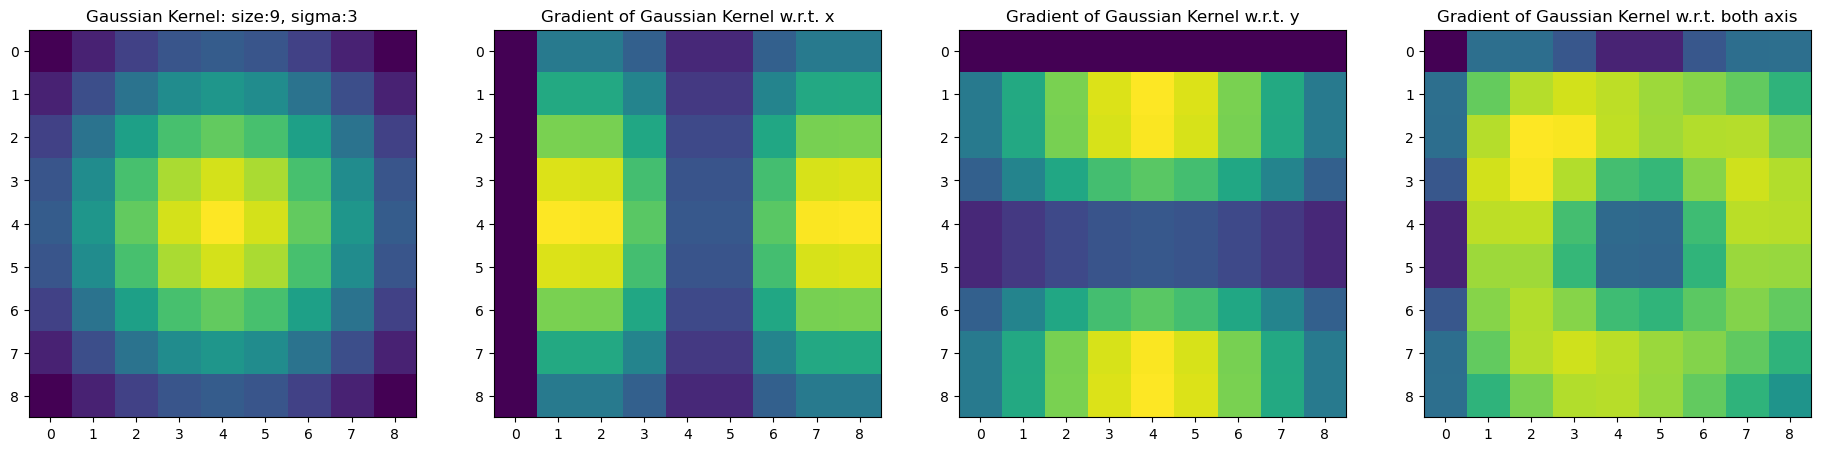

In [13]:
kernel_size = 9
kernel_sigma = 3
gaussian_kernel = get_gaussian_kernel_2d(kernel_size, kernel_sigma)

gradient_x = gradient_magnitude_x_axis(gaussian_kernel)
gradient_y = gradient_magnitude_y_axis(gaussian_kernel)
gradient = gradient_magnitude(gaussian_kernel)

figure, axes = plt.subplots(1, 4, figsize=(23, 13))

axes[0].imshow(gaussian_kernel)
axes[0].set_title("Gaussian Kernel: size:{}, sigma:{}".format(kernel_size, kernel_sigma))

axes[1].imshow(gradient_x)
axes[1].set_title("Gradient of Gaussian Kernel w.r.t. x")

axes[2].imshow(gradient_y)
axes[2].set_title("Gradient of Gaussian Kernel w.r.t. y")

axes[3].imshow(gradient)
axes[3].set_title("Gradient of Gaussian Kernel w.r.t. both axis")